In [1]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions
from vpsto.obf import OBF
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%load_ext autoreload
%autoreload 2

In [2]:
save_figures = False # set to True to save figures

In [3]:
# A class containing the forward kinematics for the 2D manipulator
class Manipulator():
    def __init__(self):
        self.l = np.array([1, 1]) # link lengths
        self.q_min = np.array([0., -np.pi])
        self.q_max = np.array([np.pi, 0.])

    # Define the forward kinematics of the manipulator
    def fk(self, q):
        # q: 2x1 array of joint angles
        # Returns: 2x1 array of end-effector position
        x0 = np.zeros(2)
        x1 = x0 + self.l[0] * np.array([np.cos(q[0]), np.sin(q[0])])
        x2 = x1 + self.l[1] * np.array([np.cos(q[0] + q[1]), np.sin(q[0] + q[1])])
        return np.vstack((x0, x1, x2))

In [4]:
# Collision environment including a square and walls
class CollisionEnvironment():
    def __init__(self):
        self.x = np.array([0.7, 0.6])
        self.w = 0.15
        self.h = 0.3
        self.x_obs_bounds = self.x + np.array([[-self.w, -self.h], [self.w, self.h]])

        self.x_min = np.array([-0.6, 0.])
        self.x_max = np.array([1.5, 1.5])

        self.N_interp = 20

        # prepare interpolation by computing a matrix that maps the points to the interpolation points
        self.interp_mat = np.zeros((self.N_interp*2, 3))
        self.interp_mat[:self.N_interp,0] = 1-np.linspace(0, 1, self.N_interp)
        self.interp_mat[:self.N_interp,1] = np.linspace(0, 1, self.N_interp)
        self.interp_mat[self.N_interp:,1] = 1-np.linspace(0, 1, self.N_interp)
        self.interp_mat[self.N_interp:,2] = np.linspace(0, 1, self.N_interp)

        
    def isTrajectoryCollision(self, pts):
        # pts: (k, 3, 2) array. Each matrix is the kinematic chain. Each row is a 2D point along the kinematic chain of the robot
        # Interpolate between the points along axis 1 to get a smooth line
        # return an array of k elements, each element is a boolean indicating if the robot is in collision at that time step
        pts_ = np.sum(self.interp_mat[None,:,:,None] * pts[:,None,:,:], axis=2) # (k, N_interp*2, 2)
        return np.any(self.isCollision(pts_), axis=1)
    
    def isRobotCollision(self, pts):
        # pts: (n, 2) array. Each row is a 2D point along the kinematic chain of the robot
        # Interpolate between the points to get a smooth line
        # Check if the pts intersects with the square
        pts_ = np.empty(((pts.shape[0]-1) * self.N_interp, 2))
        for i in range(pts.shape[0]-1):
            pts_[i*self.N_interp:(i+1)*self.N_interp] = np.linspace(pts[i], pts[i+1], self.N_interp)
        return np.any(self.isCollision(pts_))
    
    def isCollision(self, pts):
        # pts: (..., 2) array. Each row is 2D points
        # Check if the pts intersects with the square
        return np.all(np.logical_and(pts >= self.x_obs_bounds[0], pts <= self.x_obs_bounds[1]), axis=-1)

In [83]:
# Plot the robot and the collision environment
def plotEnvironment(ax, env):
    ax.set_xlim(env.x_min[0], env.x_max[0])
    ax.set_ylim(env.x_min[1], env.x_max[1])
    ax.set_aspect('equal')
    ax.add_patch(patches.Rectangle(env.x_obs_bounds[0], env.w*2, env.h*2, facecolor='r', edgecolor='None', alpha=0.5))
    ax.plot([env.x_min[0], env.x_max[0]], [env.x_min[1], env.x_min[1]], 'r', lw=3, alpha=0.5)
    ax.plot([env.x_min[0], env.x_max[0]], [env.x_max[1], env.x_max[1]], 'r', lw=3, alpha=0.5)
    ax.plot([env.x_min[0], env.x_min[0]], [env.x_min[1], env.x_max[1]], 'r', lw=3, alpha=0.5)
    ax.plot([env.x_max[0], env.x_max[0]], [env.x_min[1], env.x_max[1]], 'r', lw=3, alpha=0.5)

def plotRobot(ax, robot, q, color='k', alpha=1.):
    X = robot.fk(q)
    ax.plot(X[:,0], X[:,1], 'k', lw=3, alpha=alpha)
    if color:
        ax.plot(X[1:,0], X[1:,1], color+'o', markersize=12)
    ax.plot(X[:,0], X[:,1], 'ko', markersize=6)

In [29]:
robot = Manipulator()
env = CollisionEnvironment()

# Initial and goal joint angles
q0 = np.array([3.5*np.pi/8, -6.5*np.pi/8])
qd = np.array([3.2*np.pi/8, -3.2*np.pi/8])
q_init = 0.5 * (q0 + qd)

In [32]:
# Sample joint angles in the configuration space and check if they are collision free
n1_samples = 400
n2_samples = 400

q1 = np.linspace(robot.q_min[0], robot.q_max[0], n1_samples)
q2 = np.linspace(robot.q_min[1], robot.q_max[1], n2_samples)

c_space = np.zeros((n1_samples, n2_samples))

for i in range(n1_samples):
    for j in range(n2_samples):
        q = np.array([q1[i], q2[j]])
        X = robot.fk(q)
        if np.any(q <= robot.q_min) or np.any(q >= robot.q_max):
            c_space[j,i] = 0
        elif np.any(X[:,0] < env.x_min[0]) or np.any(X[:,0] > env.x_max[0]) or np.any(X[:,1] < env.x_min[1]) or np.any(X[:,1] > env.x_max[1]):
            c_space[j,i] = 0
        elif env.isRobotCollision(robot.fk(q)):
            c_space[j,i] = 0
        else:
            c_space[j,i] = 1

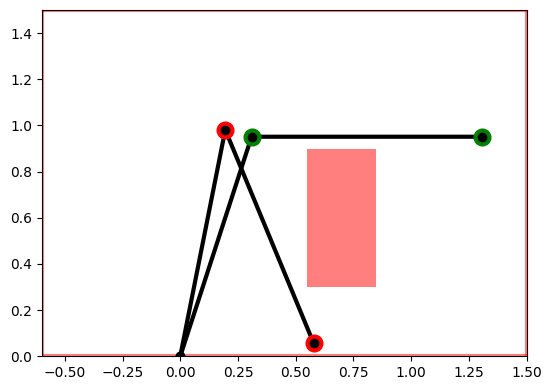

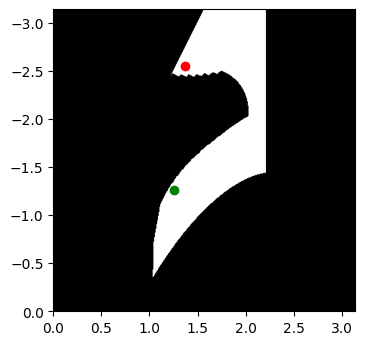

In [92]:
plt.figure(dpi=100)
# plt.xticks([])
# plt.yticks([])
ax = plt.gca()
plotEnvironment(ax, env)
plotRobot(ax, robot, q0, color='r')
plotRobot(ax, robot, qd, color='g')

plt.tight_layout()

plt.figure(figsize=(4,4), dpi=100)
ax = plt.gca()
# plt.xticks([])
# plt.yticks([])
plt.xlim(robot.q_min[0], robot.q_max[0])
plt.ylim(robot.q_min[1], robot.q_max[1])

plt.imshow(c_space, cmap='gray', extent=[robot.q_min[0], robot.q_max[0], robot.q_min[1], robot.q_max[1]], origin='lower')

plt.scatter(q0[0], q0[1], c='r', marker='o')
plt.scatter(qd[0], qd[1], c='g', marker='o')

ax.invert_yaxis()

In [34]:
# Initialize VPSTO for fast trajectory synthesis
opt = VPSTOOptions(ndof=2)
opt.N_via = 2
opt.N_eval = 50
opt.pop_size = 100
opt.log = True
vpsto = VPSTO(opt)

In [35]:
# Setup function to plot a trajectory into the C-space
def plotTrajectory(ax, q_via, color='b', lw=1, alpha=1.0):
    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via, q0, qT=qd, dqT=np.zeros(2), T=1.0)
    q_traj = q_traj.squeeze(axis=0)
    ax.plot(q_traj[:,0], q_traj[:,1], color=color, lw=lw, alpha=alpha)

In [36]:
def isViaCollision(q_via):
    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via, q0, qT=qd, dqT=np.zeros(2), T=1.0)
    q_traj = q_traj.squeeze(axis=0)
    if np.any(q_traj <= robot.q_min) or np.any(q_traj >= robot.q_max):
        return True

    X = np.empty((len(q_traj), 3, 2))
    for i in range(len(q_traj)):
        X[i] = robot.fk(q_traj[i])

    if np.any(X[:,:,0] < env.x_min[0]) or np.any(X[:,:,0] > env.x_max[0]) or np.any(X[:,:,1] < env.x_min[1]) or np.any(X[:,:,1] > env.x_max[1]):
        return True

    if np.any(env.isTrajectoryCollision(X)):
        return True
    return False

In [37]:
q1 = np.linspace(robot.q_min[0], robot.q_max[0], n1_samples)
q2 = np.linspace(robot.q_min[1], robot.q_max[1], n2_samples)

q_via_collision = np.zeros((n1_samples, n2_samples))
q_via_T = np.zeros((n1_samples, n2_samples))

for i in range(n1_samples):
    print(100*i/n1_samples, end='\r')
    for j in range(n2_samples):
        q_via = np.array([q1[i], q2[j]])
        if isViaCollision(q_via):
            q_via_collision[j,i] = 0
        else:
            q_via_collision[j,i] = 1
            q_via_T[j,i] = vpsto.vptraj.get_min_duration(q_via, q0, qT=qd, dqT=np.zeros(2))

In [38]:
def loss(candidates):
    costs = np.zeros(len(candidates['T']))
    for i in range(len(costs)):
        q_traj = candidates['pos'][i]
        q_lim_cost = (np.sum(np.minimum(q_traj[:,0] - robot.q_max[0], robot.q_min[0] - q_traj[:,0]) > 0) + 
                    np.sum(np.minimum(q_traj[:,1] - robot.q_max[1], robot.q_min[1] - q_traj[:,1]) > 0)) / (2*vpsto.opt.N_eval)

        X = np.empty((len(q_traj), 3, 2))
        for j in range(len(q_traj)):
            X[j] = robot.fk(q_traj[j])

        X_lim_cost = (np.sum(np.minimum(X[:,:,0] - env.x_max[0], env.x_min[0] - X[:,:,0]) > 0) +
                    np.sum(np.minimum(X[:,:,1] - env.x_max[1], env.x_min[1] - X[:,:,1]) > 0)) / (2*vpsto.opt.N_eval)

        q_col_cost = np.sum(env.isTrajectoryCollision(X)) / (2*vpsto.opt.N_eval)

        T = candidates['T'][i]
        costs[i] = T + 1e3 * (q_lim_cost + X_lim_cost + q_col_cost)
    return costs

vpsto.opt.sigma_init = 8
vpsto.opt.max_iter = 100
sol = vpsto.minimize(loss, q0=q0, qT=qd, dqT=np.zeros(2))
q_via_opt = sol.p_best

VP-STO finished after 83 iterations with a final loss of 25.097105258370565


### Visualize the solution

In [90]:
def plotCartesianSpace(it):
    plt.figure(dpi=100)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    plotEnvironment(ax, env)

    if it == 0:
        q_via_best = q_init
    else:
        q_via_best = sol.via_best_list[it-1]
    # plotRobot(ax, robot, q_via_best, color='m')

    q_traj, _, _ = vpsto.vptraj.get_trajectory(q_via_best, q0, qT=qd, dqT=np.zeros(2))
    q_traj = q_traj.squeeze(axis=0)

    idx = np.linspace(0, len(q_traj)-1, 7).astype(int)
    for i in idx:
        plotRobot(ax, robot, q_traj[i], color=None, alpha=.5*i/len(q_traj)+.25)

    plotRobot(ax, robot, q0, color='r', alpha=0)
    plotRobot(ax, robot, qd, color='g')

    X = np.empty((len(q_traj), 3, 2))
    for i in range(len(q_traj)):
        X[i] = robot.fk(q_traj[i])
    plt.plot(X[:,-1,0], X[:,-1,1], c='m', alpha=0.8)

    plt.tight_layout()

    if save_figures:
        plt.savefig('task_space_'+str(it)+'.png', dpi=200)

In [69]:
def plotCSpace(it):
    plt.figure(figsize=(4,4), dpi=100)
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.xlim(robot.q_min[0], robot.q_max[0])
    plt.ylim(robot.q_min[1], robot.q_max[1])

    plt.imshow(c_space, cmap='gray', extent=[robot.q_min[0], robot.q_max[0], robot.q_min[1], robot.q_max[1]], origin='lower')

    plt.scatter(q0[0], q0[1], c='r', marker='o')
    plt.scatter(qd[0], qd[1], c='g', marker='o')

    if it == 0:
        plt.scatter(q_init[0], q_init[1], c='m', marker='o')
        plotTrajectory(ax, q_init, color=(1,0,1), lw=2, alpha=1)
    else:
        q_via_best = sol.via_best_list[it-1]
        plt.scatter(q_via_best[0], q_via_best[1], c='m', marker='o')
        plotTrajectory(ax, q_via_best, color=(1,0,1), lw=2, alpha=1)
        costs = sol.loss_list[it-1]
        rewards = np.exp(-costs / np.mean(costs))
        for i in range(vpsto.opt.pop_size):
            c = (1-rewards[i], rewards[i], 0)
            q_via = sol.candidates_list[it-1][i]
            plt.scatter(q_via[0], q_via[1], color=c, marker='o', alpha=0.8)
            plotTrajectory(ax, q_via, color=c, lw=.5, alpha=0.8)

    plt.tight_layout()
    ax.invert_yaxis()

    if save_figures:
        plt.savefig('joint_space_'+str(it)+'.png', dpi=200)

In [70]:
def plotOptSpace(it):
    plt.figure(figsize=(4,4), dpi=100)
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    plt.xlim(robot.q_min[0], robot.q_max[0])
    plt.ylim(robot.q_min[1], robot.q_max[1])

    R = np.exp(-1e-1*q_via_T)
    plt.imshow(q_via_collision*R, cmap='gray', extent=[robot.q_min[0], robot.q_max[0], robot.q_min[1], robot.q_max[1]], origin='lower')

    if it == 0:
        plt.scatter(q_init[0], q_init[1], c='m', marker='o')
    else:
        q_via_best = sol.via_best_list[it-1]
        plt.scatter(q_via_best[0], q_via_best[1], c='m', marker='o')
        costs = sol.loss_list[it-1]
        rewards = np.exp(-costs / np.mean(costs))
        for i in range(vpsto.opt.pop_size):
            c = (1-rewards[i], rewards[i], 0)
            q_via = sol.candidates_list[it-1][i]
            plt.scatter(q_via[0], q_via[1], color=c, marker='o', alpha=0.8)

    plt.tight_layout()
    ax.invert_yaxis()

    if save_figures:
        plt.savefig('via_space_'+str(it)+'.png', dpi=200)

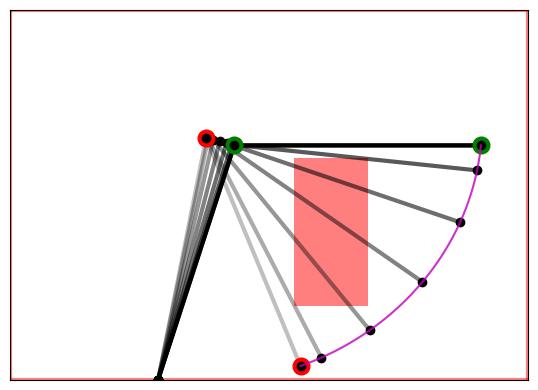

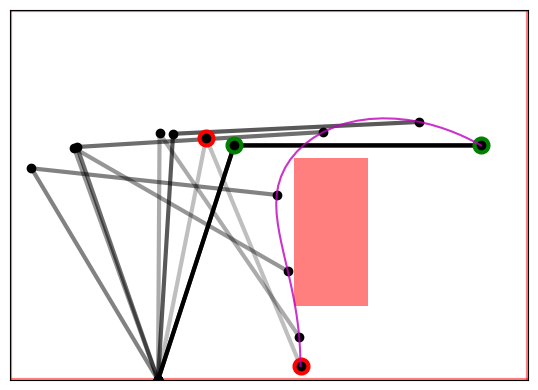

In [91]:
plotCartesianSpace(0)
plotCartesianSpace(20)

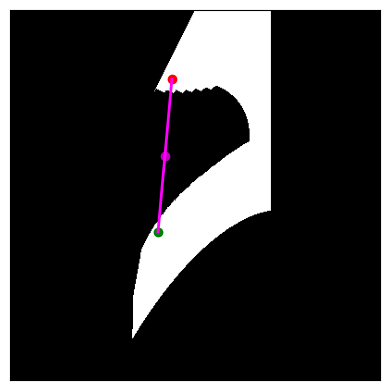

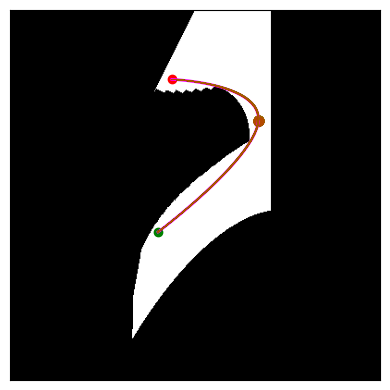

In [72]:
plotCSpace(0)
plotCSpace(20)

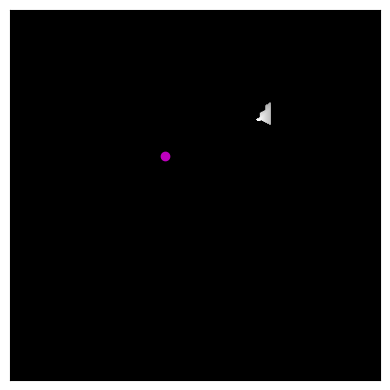

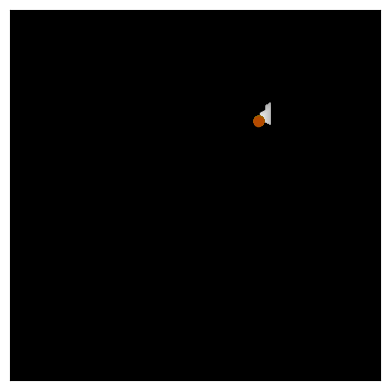

In [73]:
plotOptSpace(0)
plotOptSpace(20)